In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import shutil
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt
import gc
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from sklearn.utils import shuffle
from skimage.feature import hog
from skimage import data, exposure
from skimage import data
from skimage import io
import cv2
import seaborn as sns
sns.set(style = "dark", 
        color_codes = True,
        font_scale = 1.5)
import warnings
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
np.random.seed(42)

In [2]:
def show(image):
    """
    Display image using plt
    """
    plt.axis('off')
    plt.imshow(image)

In [3]:
label= {
            "ADI": "adipose",
            "BACK": "background",
            "DEB": "debris",
            "LYM": "lymphocytes",
            "MUC": "mucus",
            "MUS": "smooth muscle",
            "NORM": "normal colon mucosa",
            "STR": "cancer-associated stroma",
            "TUM": "colorectal adenocarcinoma epithelium"
        }

In [4]:
rootDir = r"E:\BIC Project\NCT-CRC-HE-100K"
files = [(os.path.relpath(os.path.join(dirpath), rootDir),os.path.relpath(os.path.join(dirpath, file), rootDir)) for (dirpath, dirnames, filenames) in os.walk(rootDir) for file in filenames]

In [6]:
def dataframe(files_0):
    ls = []
    for dirpath, file in files_0:
        dict_img = {}
        path = rootDir + "\\" + file
        img_PIL = np.array(Image.open(path))
        dict_img['class'] = dirpath
        dict_img['image'] = img_PIL
        ls.append(dict_img)
    df = pd.DataFrame(ls)
    return df
df_BIC = dataframe(files)
df_BIC.to_csv("E:\\BIC Project\\NCT-CRC-HE-100K\\df_BIC.csv")

In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
df_BIC = pd.read_csv("E:\\BIC Project\\NCT-CRC-HE-100K\\df_BIC.csv")[['class',"image"]]

In [3]:
df_BIC.head()

class                                              image
0   ADI  [[[185 124 173]\n  [182 116 167]\n  [191 120 1...
1   ADI  [[[157  81 134]\n  [156  78 131]\n  [159  82 1...
2   ADI  [[[215 204 225]\n  [215 204 225]\n  [214 203 2...
3   ADI  [[[229 220 233]\n  [229 219 232]\n  [230 217 2...
4   ADI  [[[235 220 233]\n  [235 220 233]\n  [235 220 2...

In [4]:
df_BIC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   class   100000 non-null  object
 1   image   100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [5]:
df_BIC['class'].value_counts(sort=False)

class
ADI     10407
BACK    10566
DEB     11512
LYM     11557
MUC      8896
MUS     13536
NORM     8763
STR     10446
TUM     14317
Name: count, dtype: int64

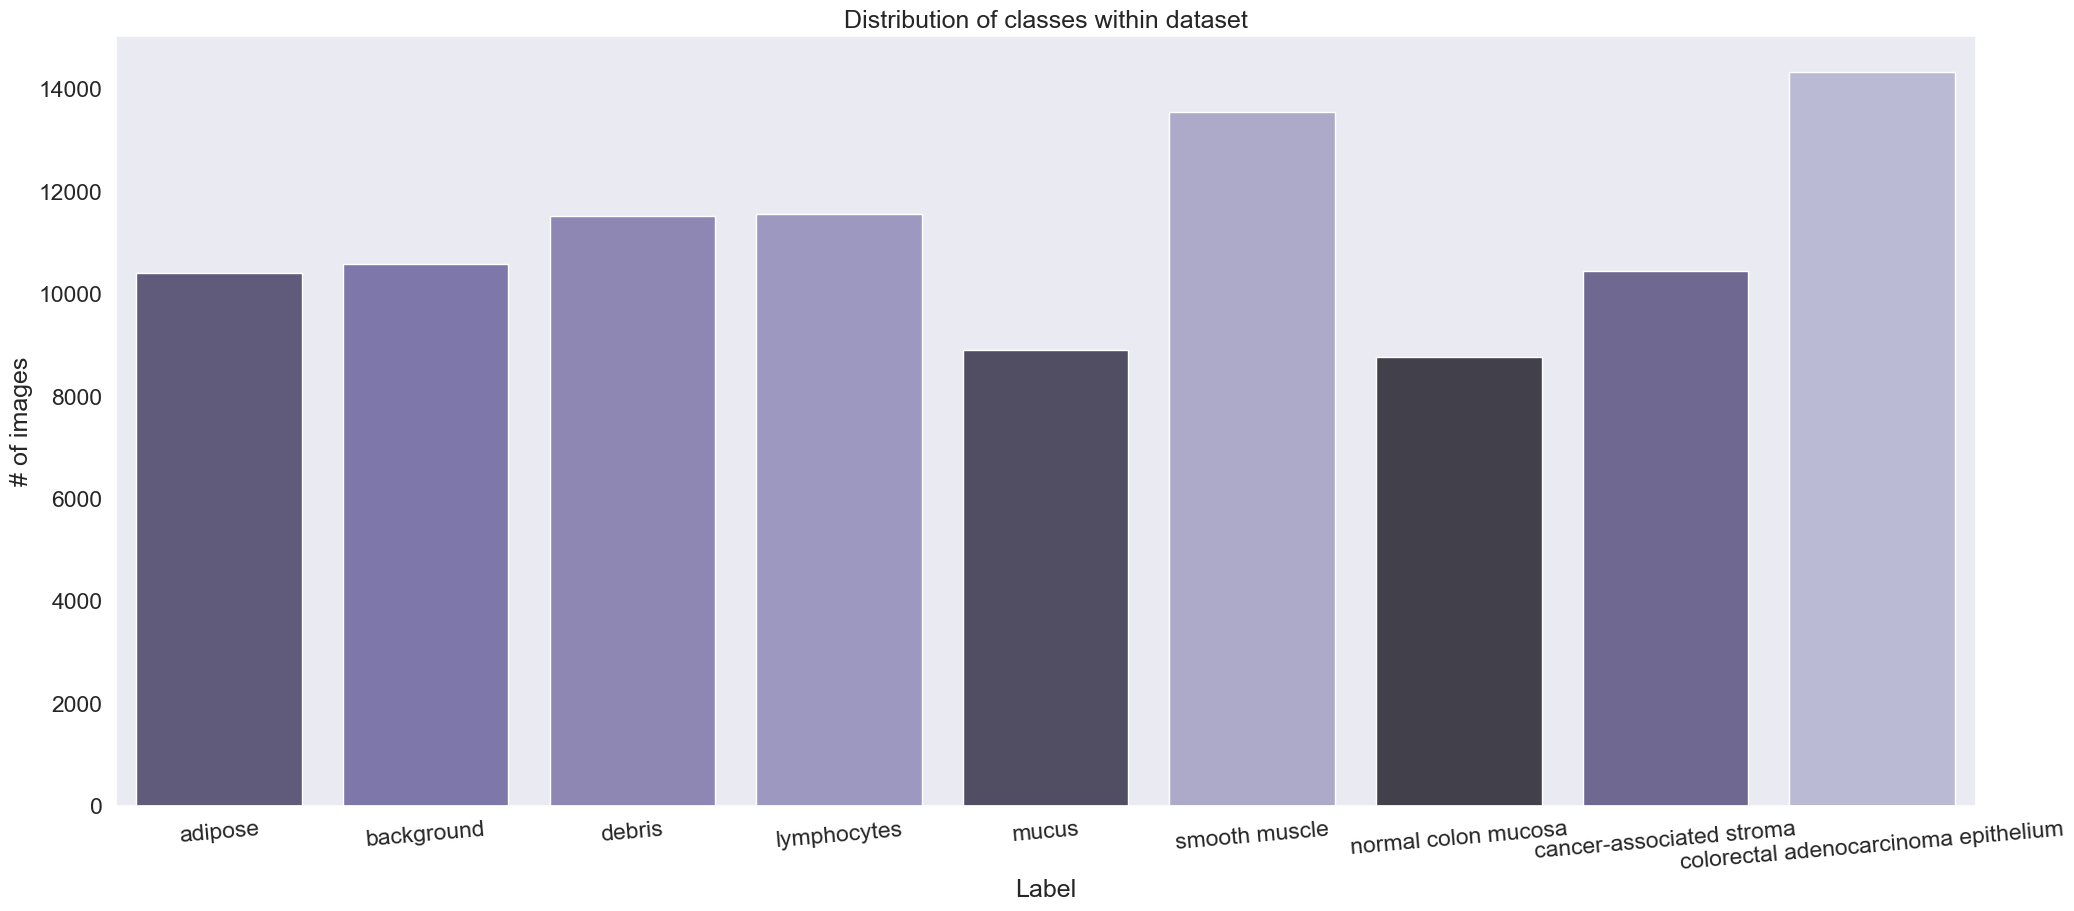

In [27]:
plt.figure(figsize=(24,10))
labels = df_BIC.groupby('class')['image'].count()
pal = sns.color_palette("Purples_d", len(labels))
rank = labels.argsort().argsort()
ax = sns.barplot(x=[label[lab] for lab in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within dataset")
plt.ylabel("# of images")
plt.xlabel("Label")
ax.set_xticklabels(ax.get_xticklabels(), rotation=5);

In [5]:
def read_training_data(subset=False):
    """
    Reading the training and validation data, assuming the folder is located in '.\NCT-CRC-HE-100K'.
    """
    data_path = rootDir
    folders = sorted(os.listdir(data_path))
    images, labels = [], []
    label_dict = {}

    if ".DS_Store" in folders:
        folders.remove(".DS_Store")
        
    print("[INFO] Reading training images")
    for label_no in range(len(folders)):
        folder = folders[label_no]
        label_dict[label_no] = folder
        oslistdir = sorted(os.listdir(f"{data_path}/{folder}"))
        oslistdir = oslistdir[:10] if subset else oslistdir
        
        for image_name in oslistdir:
            if image_name == ".DS_Store":
                continue

            image_path = f"{data_path}/{folders[label_no]}/{image_name}"
            image = io.imread(image_path)

            # If image is grayscale
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
            images.append(image)
            labels.append(label_no)
        
        print(f"\t [{((label_no + 1)/len(folders)) * 100:.1f} %] Fetching label '{folder}'           ", end='\r')
            
    print()
    df = pd.DataFrame()
    df['Image_Id'] = [i for i in range(len(images))]
    df['Image'] = images
    df['Label'] = labels
    return df, label_dict
training_data, label_dict = read_training_data()

[INFO] Reading training images
	 [100.0 %] Fetching label 'TUM'           


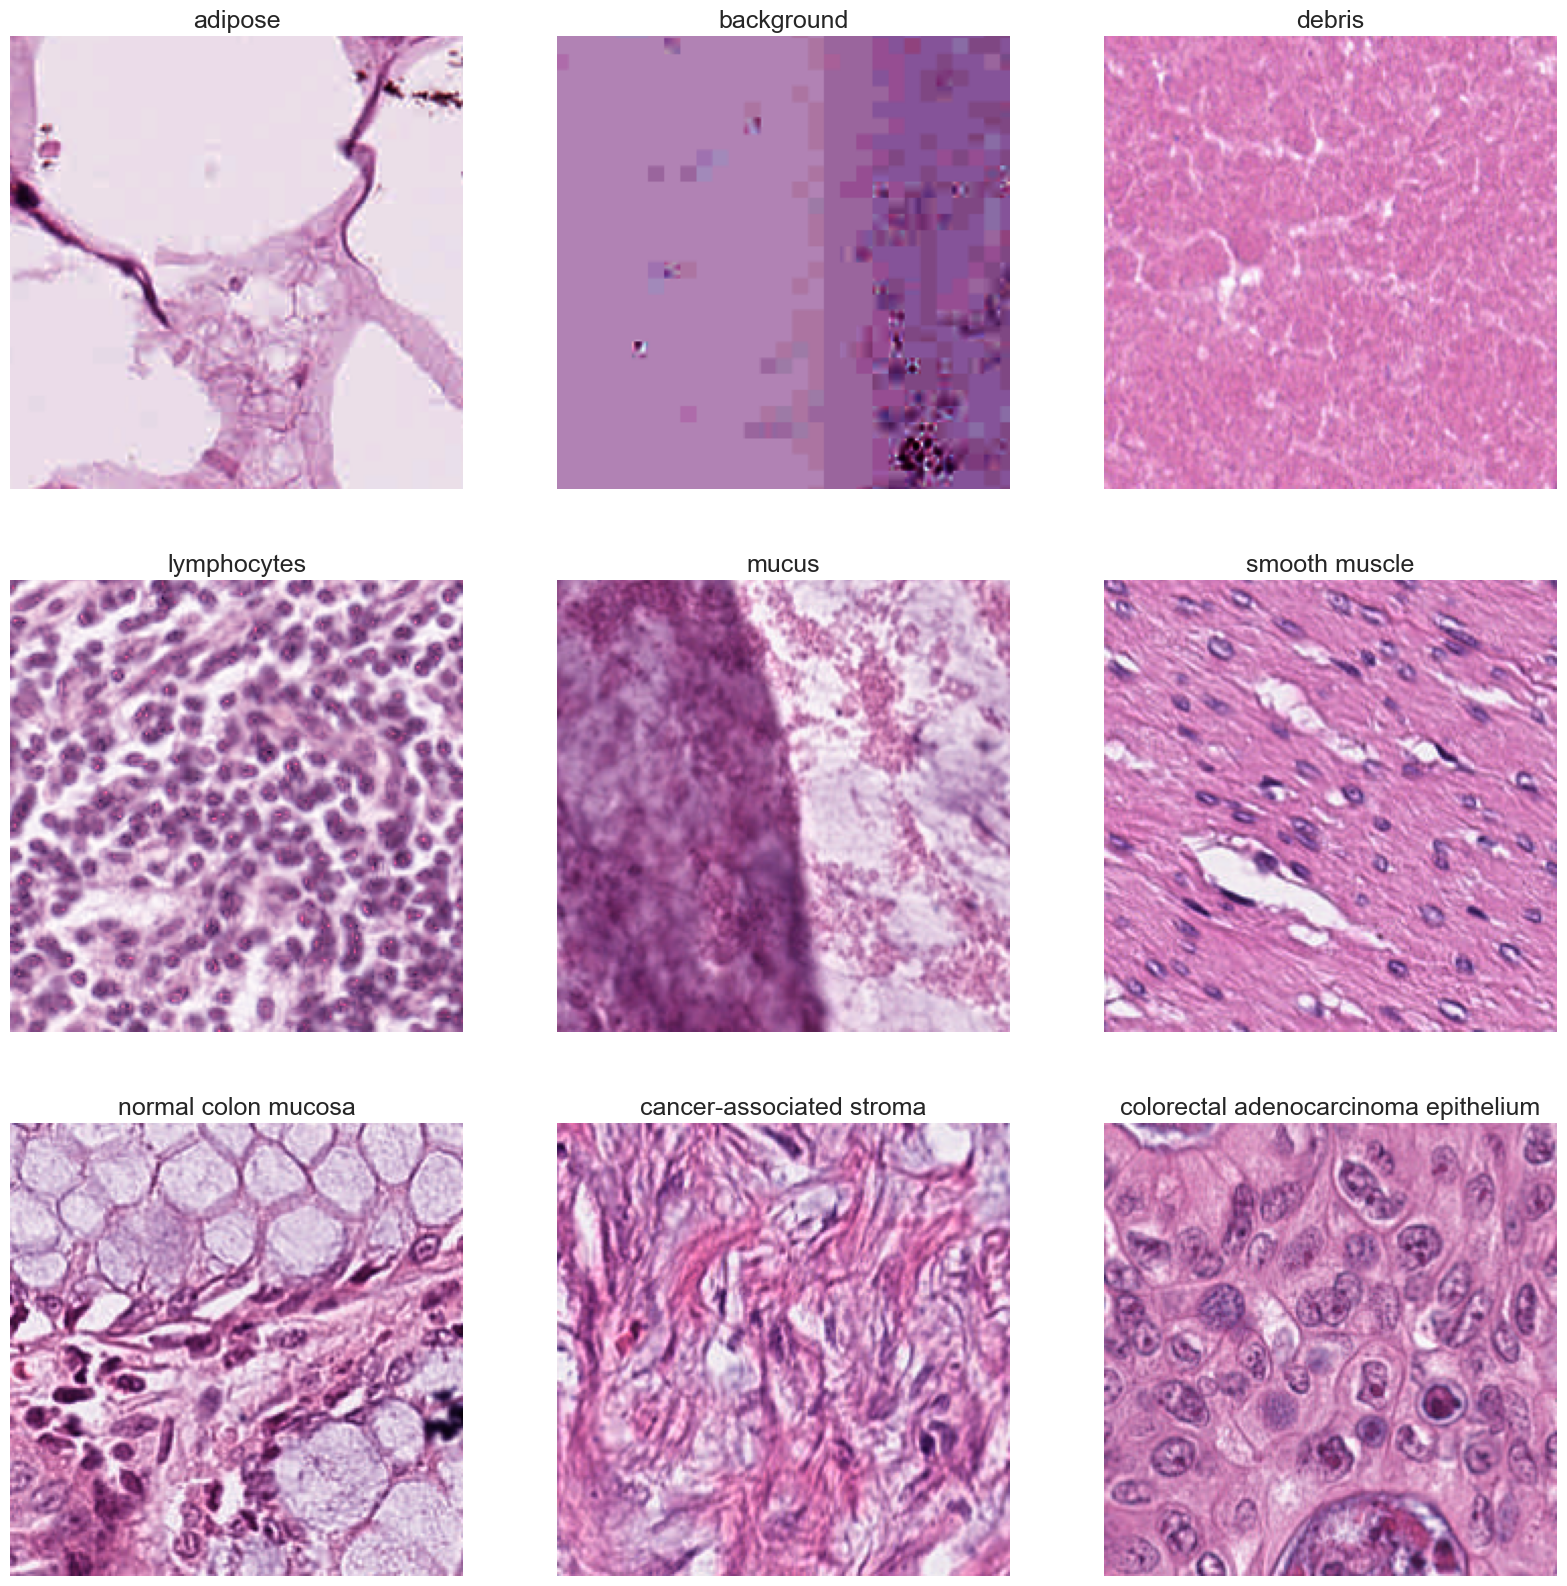

In [26]:
# Displaying the three images from the first three categories in the training set
image_by_label = training_data.groupby("Label").agg({"Image": lambda x: list(x)[0]})
image_by_label["Image"] = image_by_label["Image"].apply(np.array)
img1, img2, img3 = image_by_label["Image"].iloc[0], image_by_label["Image"].iloc[1], image_by_label["Image"].iloc[2]
[label1, label2, label3] = image_by_label.index[0:3]
# Plotting images
img = []
for i in range(len(image_by_label["Image"])):
    img.append(image_by_label["Image"].iloc[i])
# Plotting images
f, axes = plt.subplots(figsize=(20,20), ncols=3, nrows=3)
for i in range(9):
    axes[i//3][i%3].imshow(img[i])
for i in range(9):
    axes[i//3][i%3].axis('off')
for i in range(9):
    axes[i//3][i%3].title.set_text(label[label_dict[image_by_label.index[i]]])

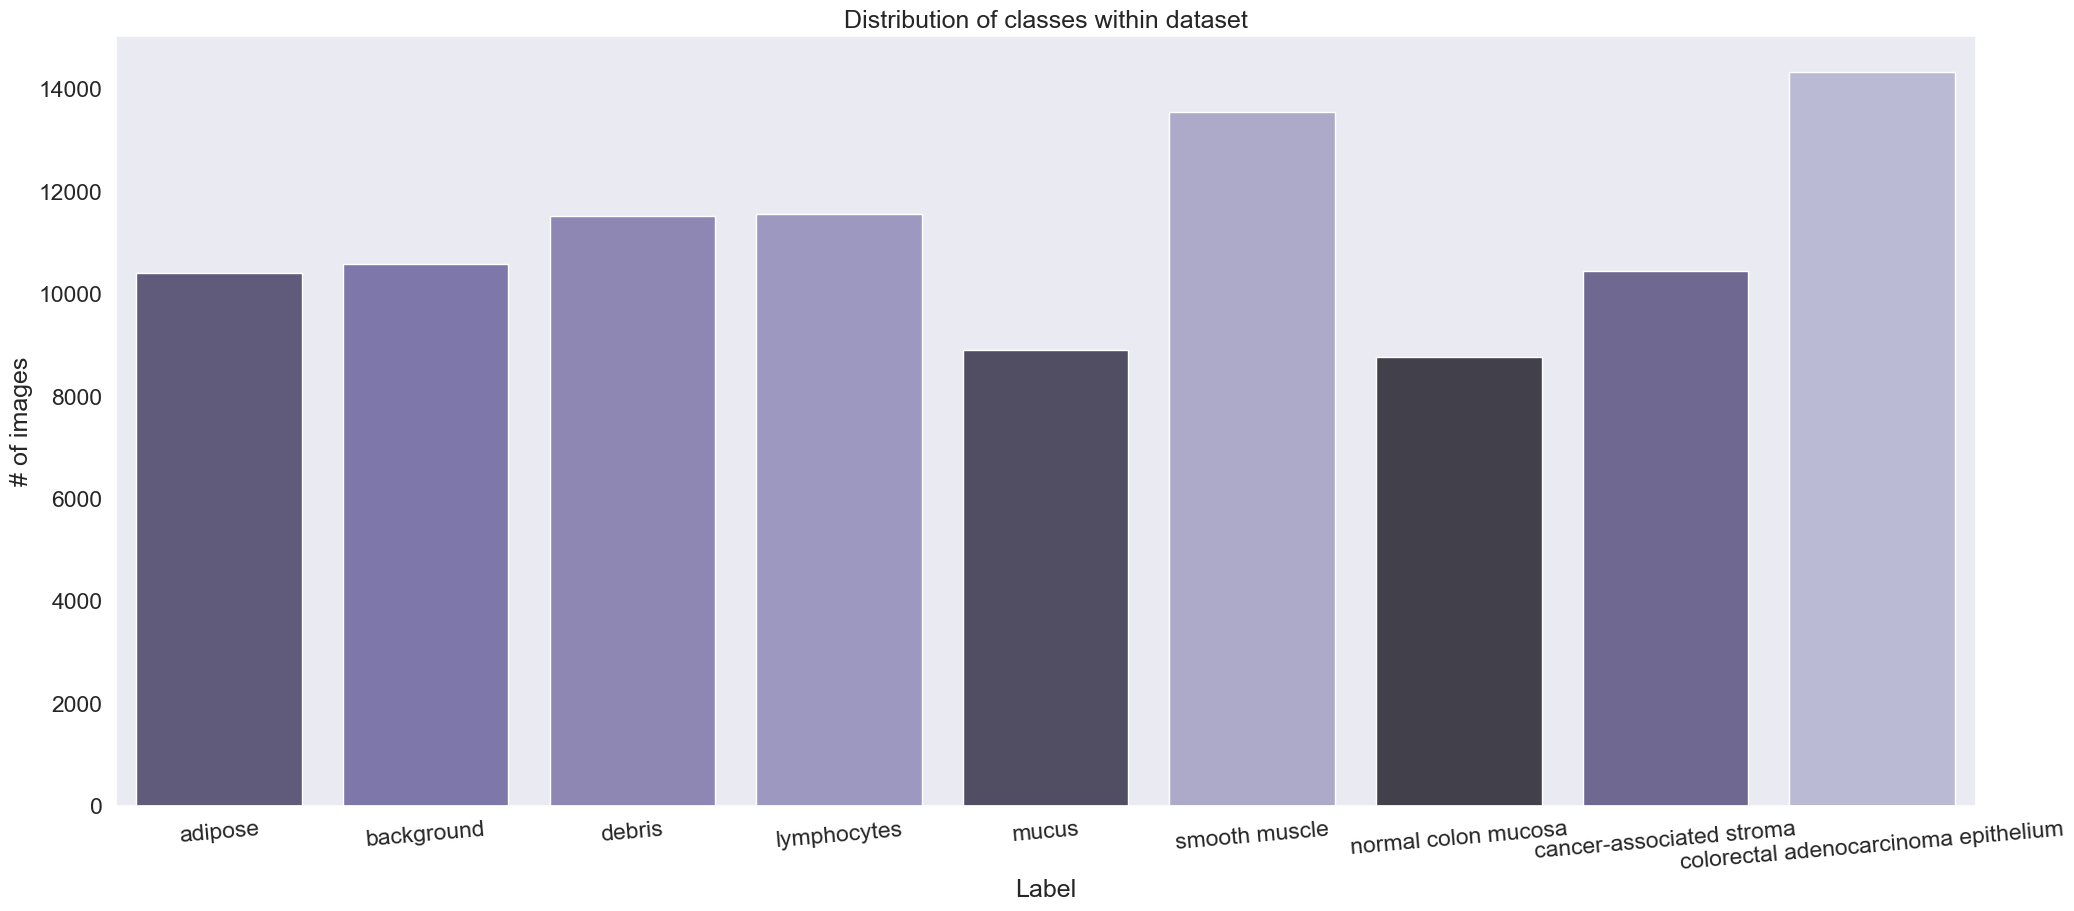

In [13]:
plt.figure(figsize=(24,10))

labels = training_data.groupby("Label")["Image"].count()

pal = sns.color_palette("Purples_d", len(labels))
rank = labels.argsort().argsort()
ax = sns.barplot(x=[label[label_dict[lab]] for lab in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within dataset")
plt.ylabel("# of images")
plt.xlabel("Label")
ax.set_xticklabels(ax.get_xticklabels(), rotation=5);

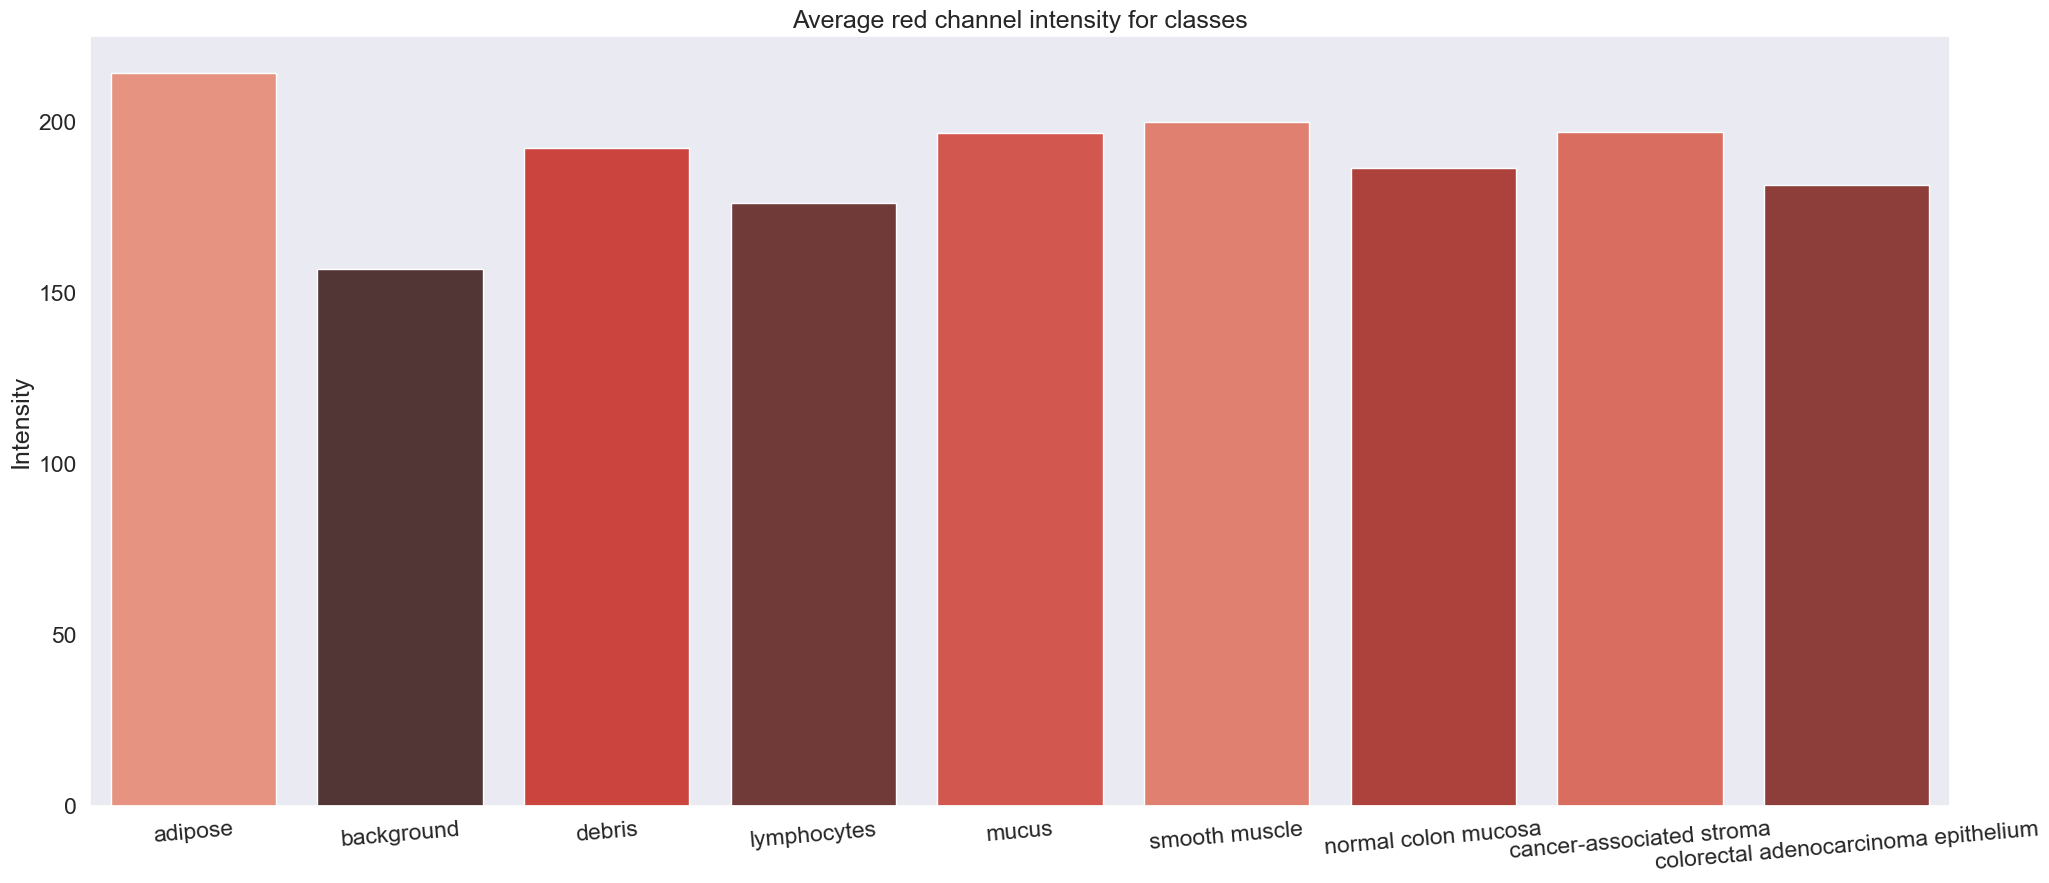

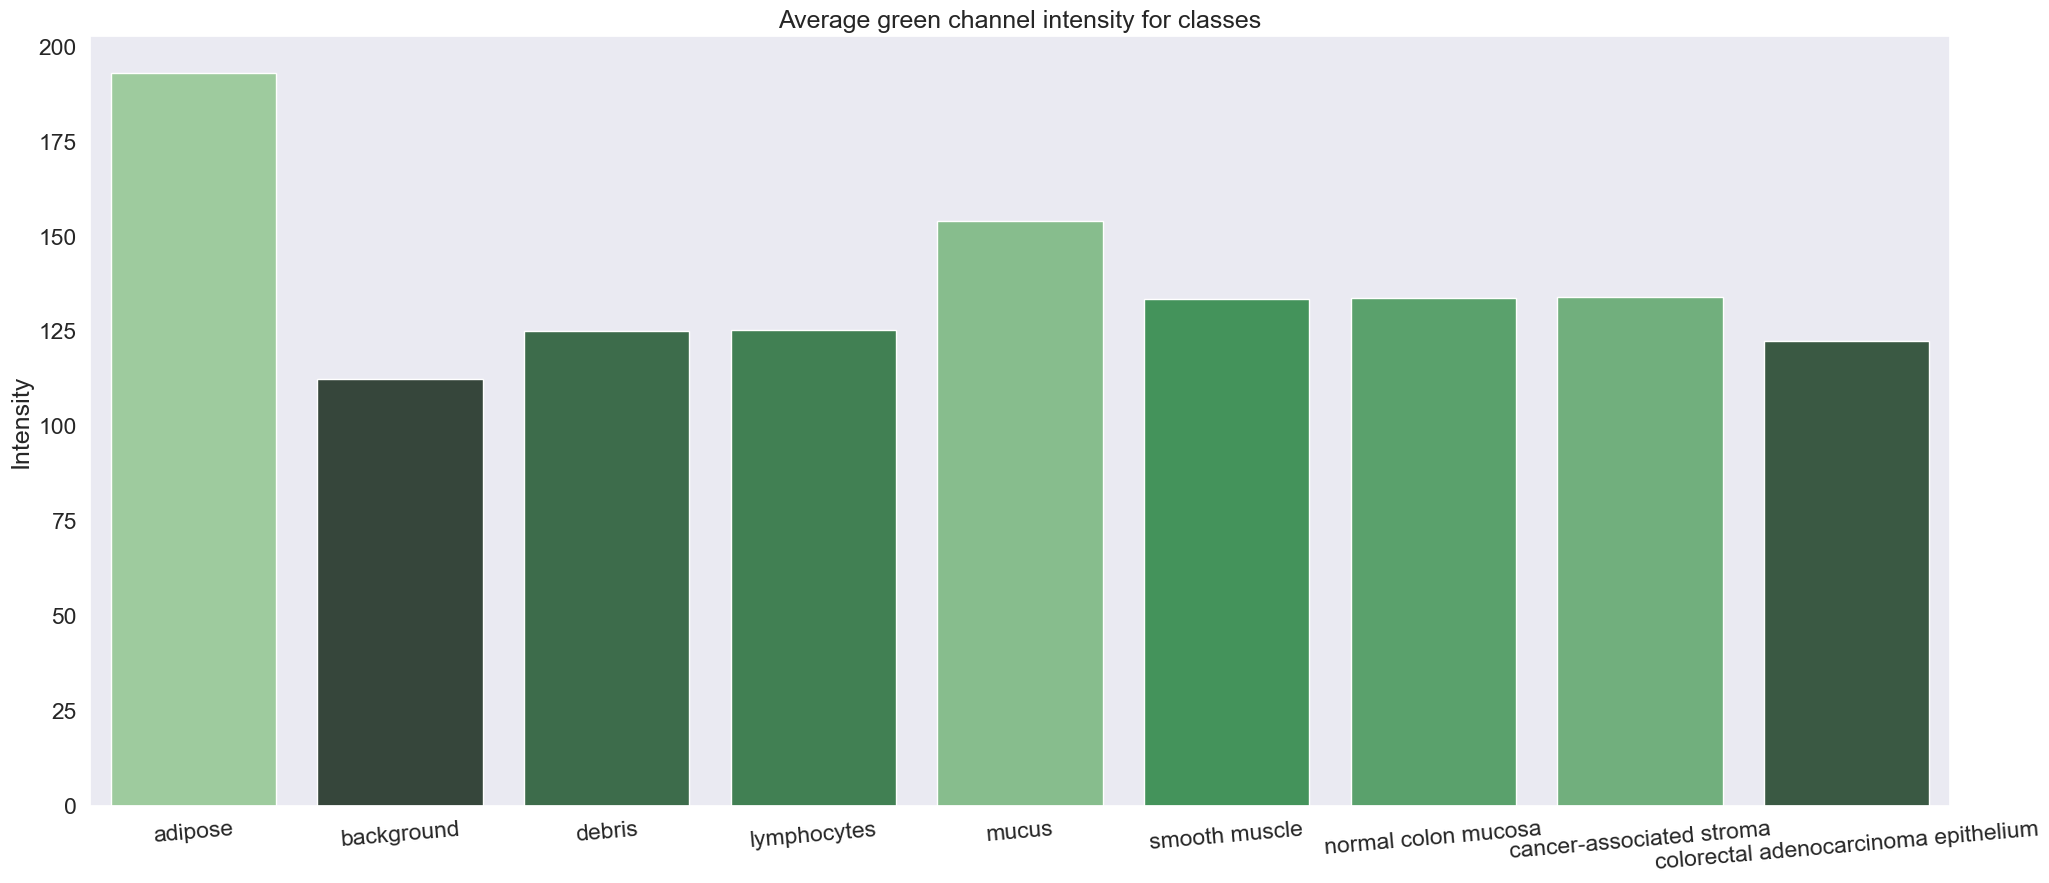

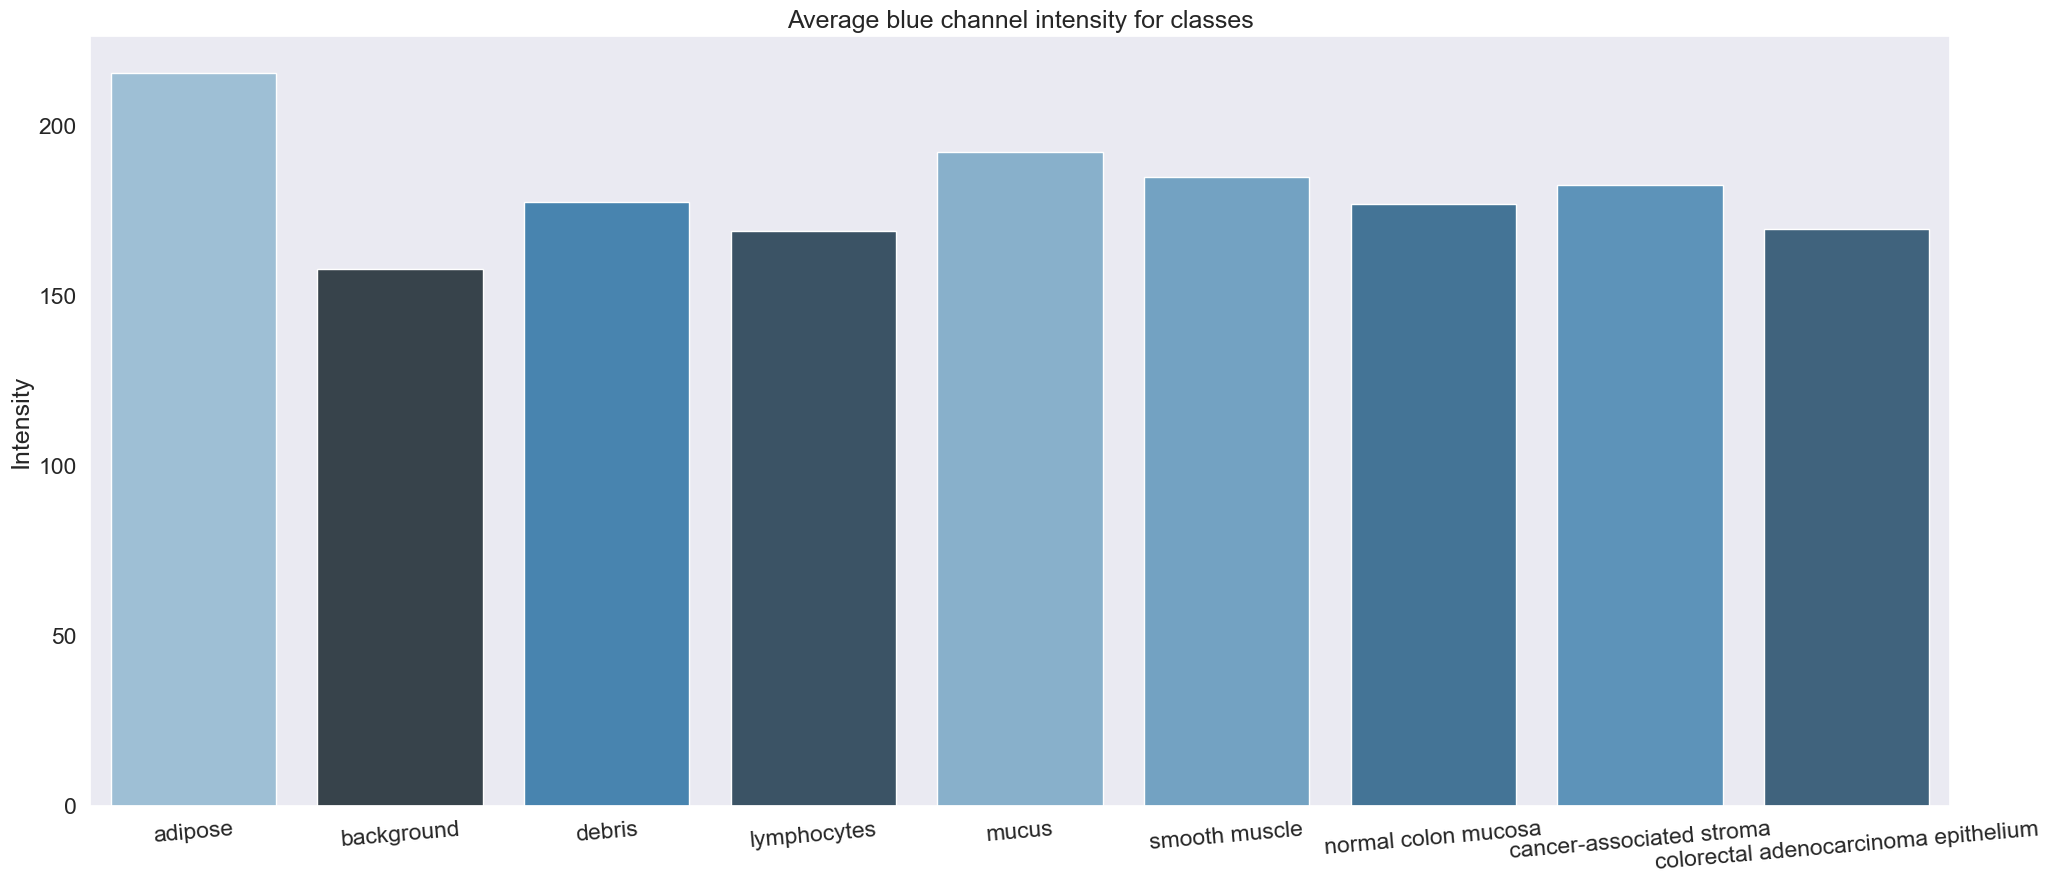

In [16]:
def calculate_channel_average(img, channel):
    """
    Calculate channel average.
    Remark: Only used for plotting
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)

# Calculating channel average over all labels
red_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="R") for img in s])}).reset_index()
green_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="G") for img in s])}).reset_index()
blue_channel_average = training_data.groupby("Label").agg({"Image": lambda s: np.mean([calculate_channel_average(img, channel="B") for img in s])}).reset_index()

def plot_channel_intensity_barplot(df, channel):
    """
    Plot a individual bar plot with specified channel
    """
    title_dict = {"r": "red", "g": "green", "b": "blue"}
    palet_dict = {"r": "Reds_d", "g": "Greens_d", "b": "Blues_d"}
    plt.figure(figsize=(24,10))

    values = df["Image"].values
    pal = sns.color_palette(palet_dict[channel], len(values))
    rank = values.argsort().argsort()
    ax = sns.barplot(x=[label[label_dict[lab]] for lab in df["Label"]], y=values, palette=np.array(pal[::-1])[rank])
    
    plt.ylabel("Intensity")
    plt.title(f"Average {title_dict[channel]} channel intensity for classes")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=5)

plot_channel_intensity_barplot(red_channel_average, "r")
plot_channel_intensity_barplot(green_channel_average, "g")
plot_channel_intensity_barplot(blue_channel_average, "b");

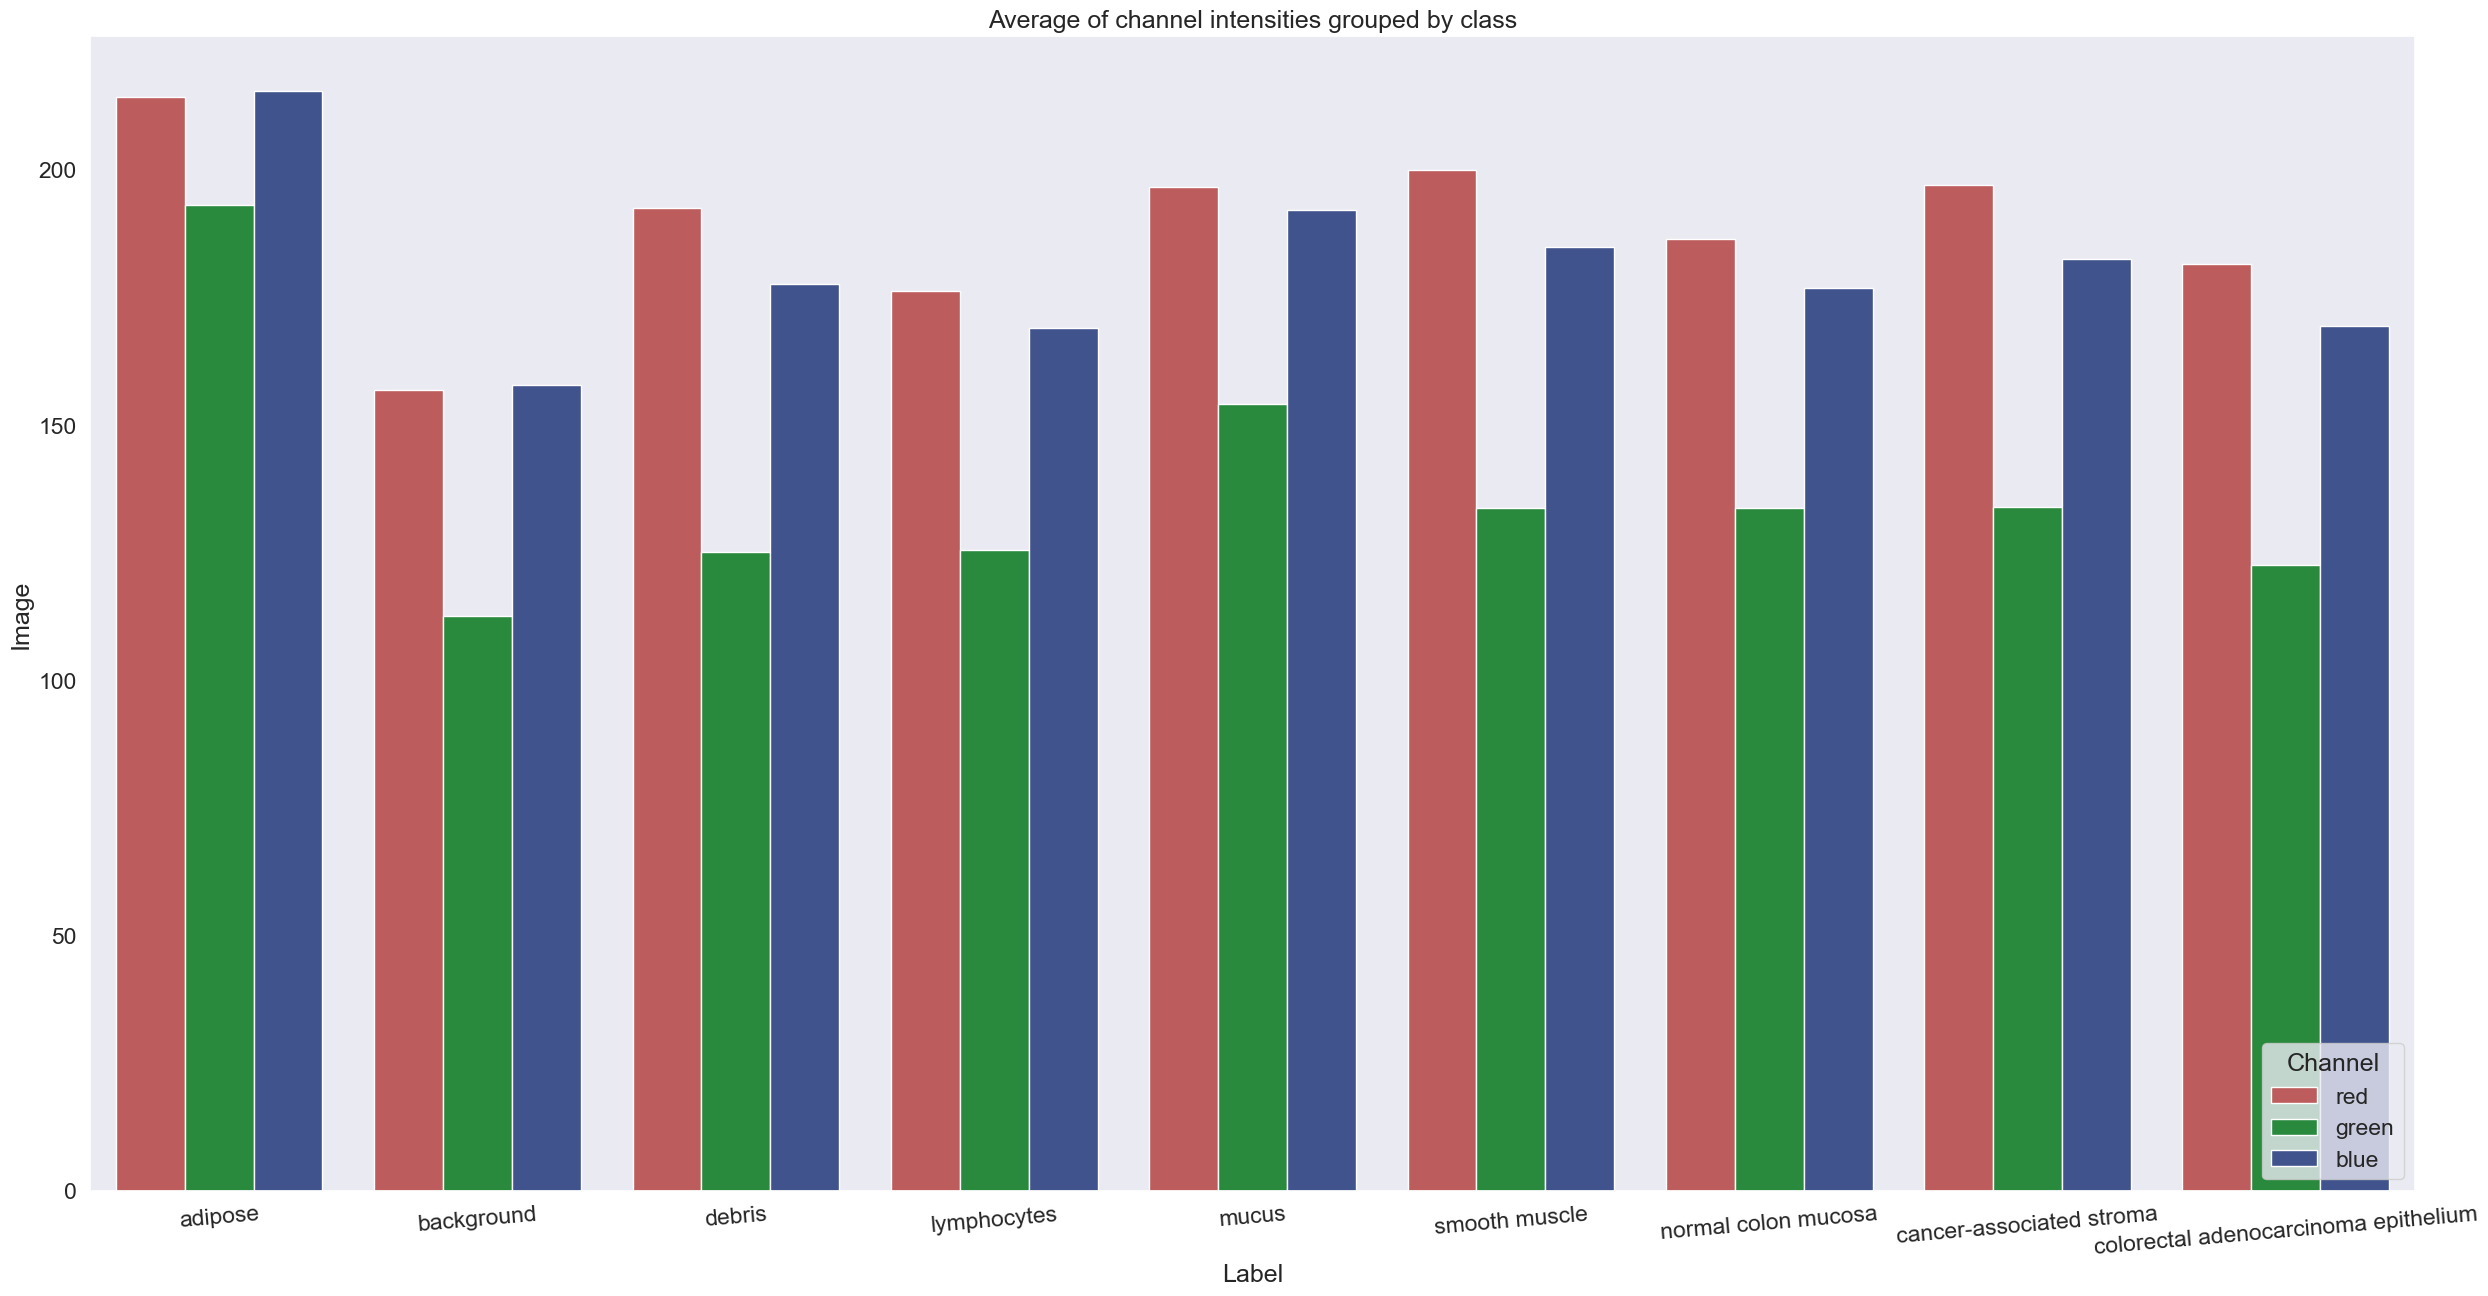

In [15]:
def set_type_array(channel, df):
    
    df["type"] = [channel for _ in range(len(df))]

set_type_array("red", red_channel_average)
set_type_array("green", green_channel_average)
set_type_array("blue", blue_channel_average)

channel_averages = pd.concat([red_channel_average, green_channel_average, blue_channel_average])
plt.figure(figsize=(30,15))

colors = [[0.8, 0.3, 0.3], [0.1, 0.6, 0.2], [0.2, 0.3, 0.6] ]

ax = sns.barplot(x=[label[label_dict[lab]] for lab in channel_averages["Label"]], y="Image", hue="type", data=channel_averages, palette=colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=5);
plt.xlabel("Label")
plt.title("Average of channel intensities grouped by class")
ax.legend(title="Channel",loc="lower right");

In [ ]:
def image_size(image):
    """
    Returns the pixel size of the image
    """
    return image.size

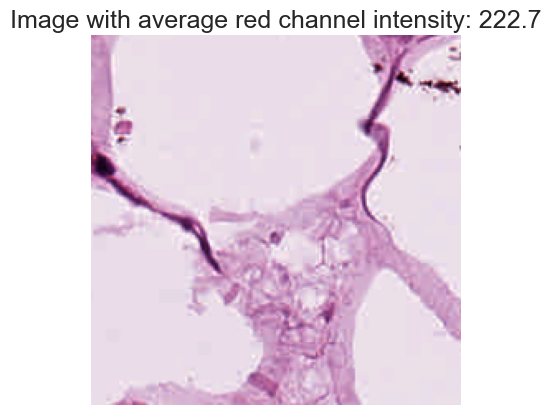

In [29]:
def average_channel_intensity(image, channel):
    """
    Returning the average channel intensity (R, G or B) of an image
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in image]).flatten()
    return np.mean(channel_intensities)

avg_r = average_channel_intensity(training_data.Image[0], "R")
show(training_data.Image[0])
plt.title(f"Image with average red channel intensity: {avg_r:.1f}")
plt.axis('off');

In [ ]:
def standard_deviation_channel_intensity(image, channel):
    """
    Returning the average channel intensity (R, G or B) of an image
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in image]).flatten()
    return np.std(channel_intensities)

In [ ]:
def aspectratio(image):
    """
    Returns the aspect ratio of the image (width/height)
    """
    return len(image[0])/len(image)

In [30]:
def grayscale_intensity(image):
    """
    Calculating the average grayscale intensity for all pixels given an image
    """
    grayscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(grayscaled_image)

print("ADI:", grayscale_intensity(training_data["Image"][1]))
print("DEB:", grayscale_intensity(training_data["Image"][30003]))

ADI: 200.14630500637756
DEB: 152.02804129464286
